#Advanced Customer Segmentation and Predictive Analysis

performing customer segmentation and building a predictive model to identify potential high-value customers. This involves cleaning and enriching the data, performing clustering, and predicting customer lifetime value (CLV) to help prioritizing marketing efforts.

##Dataset
[Online Retail Dataset](https://archive.ics.uci.edu/ml/datasets/online+retail), a transactional dataset from a UK-based online retailer from December 2010 to December 2011.

In [1]:
import pandas
import numpy
import matplotlib.pyplot
import matplotlib.ticker
import seaborn as sns
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt


## Data Aqcuisition

In [2]:
retail = pandas.read_excel("Online Retail.xlsx")

retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
retail.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


## Handling missing values

In [5]:
retail["CustomerID"] = retail["CustomerID"].fillna("Guest")
retail["Description"] = retail["Description"].fillna("No description")
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
retail = retail.drop_duplicates(subset = ["InvoiceNo", "StockCode"], keep = "first")
retail.shape

(531225, 8)

## Handling negative and zero values in **UnitPrice** and **Quantity** columns

In [7]:
retail = retail[(retail["Quantity"] > 0) & (retail["UnitPrice"] > 0)]
retail.shape

(519582, 8)

## saving the cleaned dataset

In [8]:
retail.to_csv("advanced_cleaned_retail.csv")

In [9]:
cleaned_retails = pandas.read_csv("advanced_cleaned_retail.csv")
cleaned_retails.head()

<ipython-input-9-971d1c8e25f6>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  cleaned_retails = pandas.read_csv("advanced_cleaned_retail.csv")


,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [10]:
cleaned_retails = cleaned_retails.drop("Unnamed: 0", axis = 1)
cleaned_retails.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Feature Egineering

In [11]:
cleaned_retails["TotalPrice"] = cleaned_retails["Quantity"] * cleaned_retails["UnitPrice"]
cleaned_retails.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [12]:
cleaned_retails["InvoiceDate"] = pandas.to_datetime(cleaned_retails["InvoiceDate"])
cleaned_retails["Year"] = cleaned_retails["InvoiceDate"].dt.year
cleaned_retails["Month"] = cleaned_retails["InvoiceDate"].dt.month
cleaned_retails["Day"] = cleaned_retails["InvoiceDate"].dt.day
cleaned_retails["Day_of_week"] = cleaned_retails["InvoiceDate"].dt.day_name()
cleaned_retails["InvoiceDate"] = cleaned_retails["InvoiceDate"].dt.date
cleaned_retails.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Year,Month,Day,Day_of_week
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30,2010,12,1,Wednesday
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00,2010,12,1,Wednesday
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday


In [13]:
cleaned_retails["Month"].unique()

array([12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32)

## Treating months **November, Decmeber, and January** as holiday season

In [14]:
cleaned_retails["HolidayPeriod"] = numpy.where(cleaned_retails["Month"].isin([1, 11, 12]), 1, 0)
cleaned_retails.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Year,Month,Day,Day_of_week,HolidayPeriod
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30,2010,12,1,Wednesday,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00,2010,12,1,Wednesday,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday,1


## Calculating RFM (Recency, Frequency, and Monetary) for customers

In [15]:
recency_group = cleaned_retails.groupby("CustomerID").agg({"InvoiceDate": "max"})
recency_group.head()

,InvoiceDate
CustomerID,
12346.0,2011-01-18
12347.0,2011-12-07
12348.0,2011-09-25
12349.0,2011-11-21
12350.0,2011-02-02


In [35]:
last_purchase = cleaned_retails.groupby("CustomerID")["InvoiceDate"].transform("max")
last_purchase = pandas.to_datetime(last_purchase)
cleaned_retails["Recency"] = (last_purchase - cleaned_retails["InvoiceDate"])
cleaned_retails["Recency"] = cleaned_retails["Recency"].dt.days.astype("int16")
cleaned_retails.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Year,Month,Day,Day_of_week,HolidayPeriod,Recency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30,2010,12,1,Wednesday,1,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday,1,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00,2010,12,1,Wednesday,1,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday,1,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday,1,1


In [36]:
frequency_group = cleaned_retails.groupby("CustomerID").agg({"InvoiceNo": "nunique"})
frequency_group.head()

,InvoiceNo
CustomerID,
12346.0,1
12347.0,7
12348.0,4
12349.0,1
12350.0,1


In [37]:
frequency = cleaned_retails.groupby("CustomerID").agg(Frequency = ("InvoiceNo", "nunique"))
cleaned_retails = cleaned_retails.merge(frequency, on = "CustomerID", how = "left")
cleaned_retails.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Year,Month,Day,Day_of_week,HolidayPeriod,Recency,Frequency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30,2010,12,1,Wednesday,1,1,34
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday,1,1,34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00,2010,12,1,Wednesday,1,1,34
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday,1,1,34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday,1,1,34


In [38]:
monetary_group = cleaned_retails.groupby("CustomerID").agg({"TotalPrice": "sum"})
monetary_group.head()

,TotalPrice
CustomerID,
12346.0,77183.60
12347.0,4310.00
12348.0,1595.64
12349.0,1757.55
12350.0,334.40


In [39]:
monetary = cleaned_retails.groupby("CustomerID").agg(Monetary = ("TotalPrice", "sum"))
cleaned_retails = cleaned_retails.merge(monetary, on = "CustomerID", how = "left")
cleaned_retails.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Year,Month,Day,Day_of_week,HolidayPeriod,Recency,Frequency,Monetary
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30,2010,12,1,Wednesday,1,1,34,5391.21
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday,1,1,34,5391.21
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00,2010,12,1,Wednesday,1,1,34,5391.21
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday,1,1,34,5391.21
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday,1,1,34,5391.21


## Saving the feature engineered dataset

In [40]:
cleaned_retails.to_csv("customer_features.csv")
featured_retail = pandas.read_csv("customer_features.csv")
featured_retail.head()

<ipython-input-40-d1eb4b1cf613>:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  featured_retail = pandas.read_csv("customer_features.csv")


,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Year,Month,Day,Day_of_week,HolidayPeriod,Recency,Frequency,Monetary
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30,2010,12,1,Wednesday,1,1,34,5391.21
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday,1,1,34,5391.21
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00,2010,12,1,Wednesday,1,1,34,5391.21
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday,1,1,34,5391.21
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday,1,1,34,5391.21


In [41]:
featured_retail.drop("Unnamed: 0", axis = 1, inplace = True)
featured_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Year,Month,Day,Day_of_week,HolidayPeriod,Recency,Frequency,Monetary
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30,2010,12,1,Wednesday,1,1,34,5391.21
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday,1,1,34,5391.21
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00,2010,12,1,Wednesday,1,1,34,5391.21
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday,1,1,34,5391.21
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday,1,1,34,5391.21


## Data Visualization and Analysis

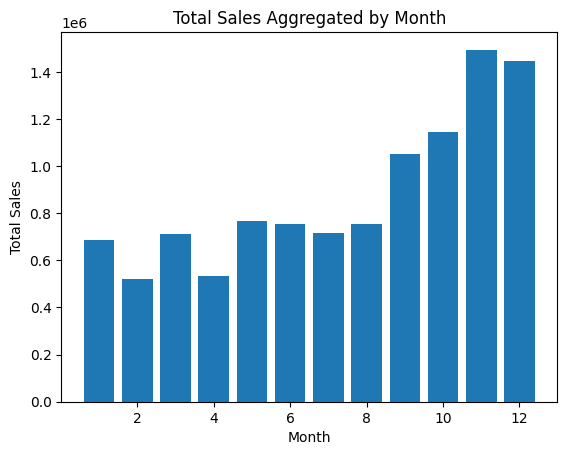

In [42]:
monthly_sales = featured_retail.groupby("Month")["TotalPrice"].sum()

plt.bar(monthly_sales.index, monthly_sales.values)
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.title("Total Sales Aggregated by Month")
plt.show()

During the identified and selected holiday months, we have the most sales, especially during the months **November** and **December**.

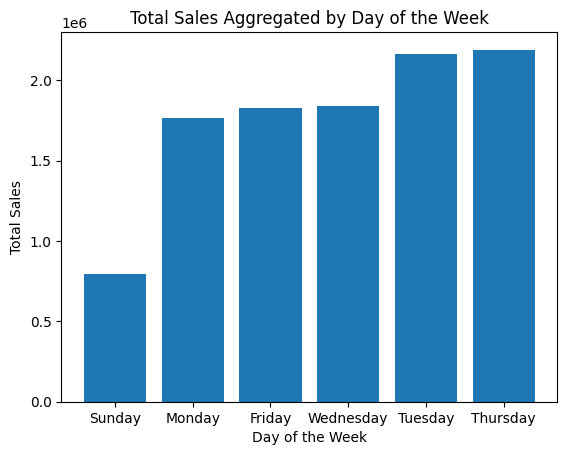

In [43]:
day_of_week_sales = featured_retail.groupby("Day_of_week")["TotalPrice"].sum().sort_values() #sort_index() does not work

plt.bar(day_of_week_sales.index, day_of_week_sales.values)
plt.xlabel("Day of the Week")
plt.ylabel("Total Sales")
plt.title("Total Sales Aggregated by Day of the Week")
plt.show()

The dataset contains no information on sales on **Saturday**. By analysing the sales on days of the week, it is clear that Sunday has the least amount of sales, but **Tuesdays** and **Thursdays** have the most sales during the week.

<ipython-input-44-091764ecf9ca>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = sales_by_period.index, y = sales_by_period.values, palette = ["lightblue", "red"])


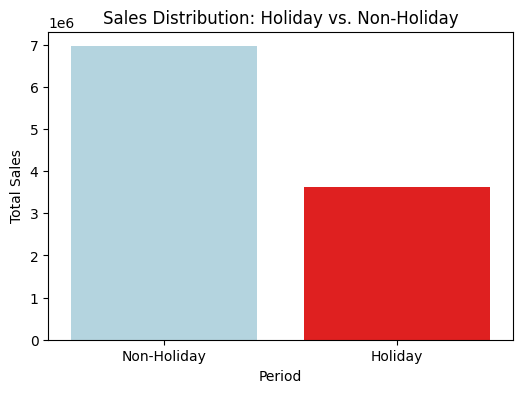

In [44]:
sales_by_period = featured_retail.groupby("HolidayPeriod")["TotalPrice"].sum()

plt.figure(figsize=(6, 4))
sns.barplot(x = sales_by_period.index, y = sales_by_period.values, palette = ["lightblue", "red"])
plt.xticks(ticks = [0, 1], labels = ["Non-Holiday", "Holiday"])
plt.ylabel("Total Sales")
plt.xlabel("Period")
plt.title("Sales Distribution: Holiday vs. Non-Holiday")
plt.show()

This plot clearly shows that almost half of the sales are during the holidays, **Novemer**, **December**, and **January**.

## RFM Visualization for anlysis

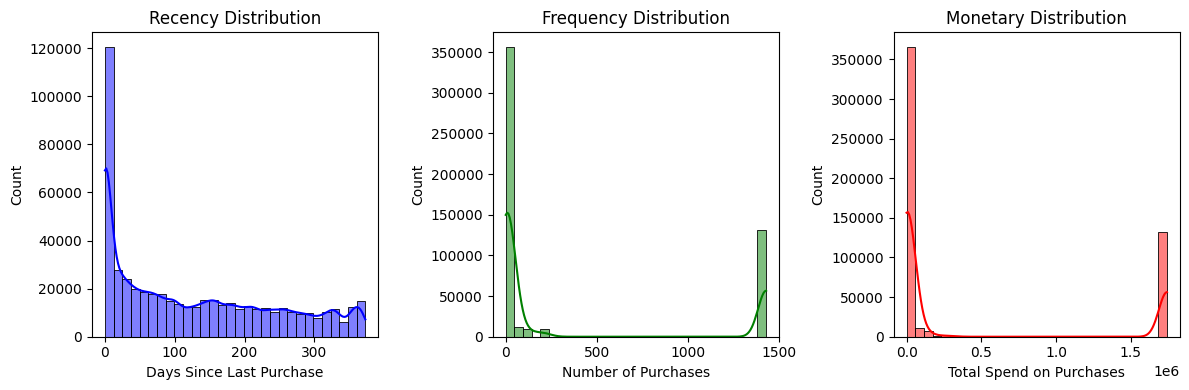

In [47]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.histplot(featured_retail["Recency"], bins = 30, kde = True, color = "blue")
plt.title("Recency Distribution")
plt.xlabel("Days Since Last Purchase")

plt.subplot(1, 3, 2)
sns.histplot(featured_retail["Frequency"], bins = 30, kde = True, color = "green")
plt.title("Frequency Distribution")
plt.xlabel("Number of Purchases")

plt.subplot(1, 3, 3)
sns.histplot(featured_retail["Monetary"], bins = 30, kde = True, color = "red")
plt.title("Monetary Distribution")
plt.xlabel("Total Spend on Purchases")

plt.tight_layout()
plt.show()


* The Recency indicates that most of the customers (almost 120,000) are regularly bying products.
* Frequency distribution shows some guest customers who don't return. but still there are a great number of customers (almost 150,000) who are loyal ones.
* Monetary distribution indicates that many customers tend to or can afford to purchase in lower amounts.

## KMeans Clustering

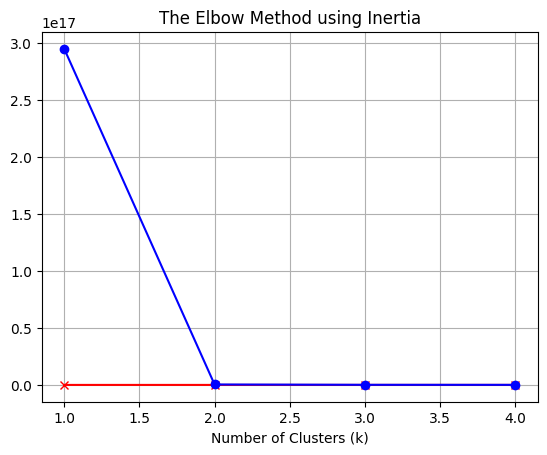

In [67]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 5)
X = featured_retail[["Recency", "Frequency", "Monetary"]]
for k in K:
    kmeanModel = KMeans(n_clusters = k, random_state = 42).fit(X)

    distortions.append(sum(numpy.min(cdist(X, kmeanModel.cluster_centers_, "euclidean"), axis = 1)**2) / X.shape[0])

    inertias.append(kmeanModel.inertia_)

    mapping1[k] = distortions[-1]
    mapping2[k] = inertias[-1]

plt.plot(K, distortions, 'rx-')
plt.xlabel('Number of Clusters (k)')
plt.title('The Elbow Method using Distortion')

plt.plot(K, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.title('The Elbow Method using Inertia')

plt.grid()
plt.show()

apparently the optimum number of clusters are **2** based on RFM features.

<ipython-input-73-977a73434c7b>:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


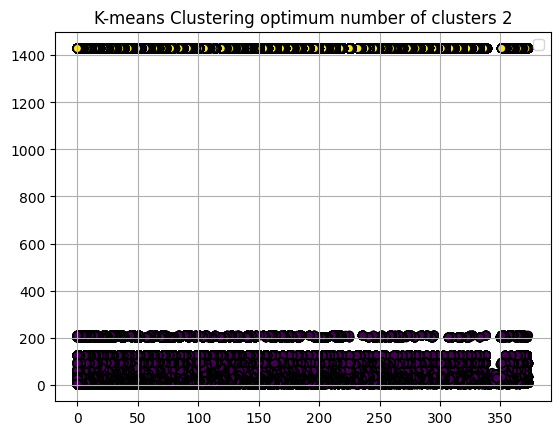

In [73]:
kmeans = KMeans(n_clusters = 2, init = "k-means++", random_state = 42)
y_kmeans = kmeans.fit_predict(X)

kmeans = KMeans(n_clusters = 2, init = "k-means++", random_state = 42)
y_kmeans = kmeans.fit_predict(X)

X_array = X.values

plt.scatter(X_array[:, 0], X_array[:, 1], c = y_kmeans, cmap = "viridis",
            marker = "o", edgecolor = "k")
plt.title("K-means Clustering optimum number of clusters 2")
plt.legend()
plt.grid()
plt.show()

In [75]:
featured_retail["Cluster"] = kmeans.labels_
featured_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Year,Month,Day,Day_of_week,HolidayPeriod,Recency,Frequency,Monetary,Cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30,2010,12,1,Wednesday,1,1,34,5391.21,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday,1,1,34,5391.21,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00,2010,12,1,Wednesday,1,1,34,5391.21,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday,1,1,34,5391.21,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1,Wednesday,1,1,34,5391.21,0


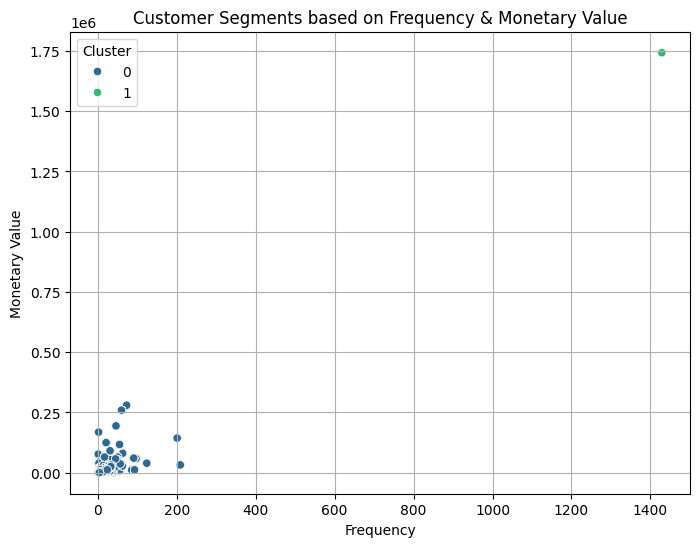

In [76]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x = featured_retail["Frequency"],
    y = featured_retail["Monetary"],
    hue = featured_retail["Cluster"],
    palette = "viridis"
)
plt.xlabel("Frequency")
plt.ylabel("Monetary Value")
plt.title("Customer Segments based on Frequency & Monetary Value")
plt.legend(title = "Cluster")
plt.grid()
plt.show()

In [84]:
cluster_summary = featured_retail.groupby("Cluster")[["Recency", "Frequency", "Monetary"]].mean().round()
cluster_count = featured_retail["Cluster"].value_counts()
cluster_summary["Count"] = cluster_count
cluster_summary

,Recency,Frequency,Monetary,Count
Cluster,,,,
0,111.0,19.0,11589.0,387839
1,176.0,1429.0,1742524.0,131743


Based on the clusters summary most of the customers have an average Recency of 111 days with a low Frequency, but an acceptable Monetary. Most of the customers in custer 1 can be considered as loyal, since both the MOnetary and Frequency are high in average.

In [78]:
featured_retail.to_csv("customer_segments.csv", index=False)

## Regression

In [91]:
featured_retail.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'TotalPrice', 'Year', 'Month',
       'Day', 'Day_of_week', 'HolidayPeriod', 'Recency', 'Frequency',
       'Monetary', 'Cluster'],
      dtype='object')

In [92]:
y = featured_retail["Monetary"]
X = featured_retail[["Recency", "Frequency", "Monetary", "Month", "HolidayPeriod"]]

In [93]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size = 0.25, random_state = 42)

In [95]:
regression_model = sklearn.linear_model.LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_predicted = regression_model.predict(X_test)

In [98]:
r2_score = sklearn.metrics.r2_score(y_test, y_predicted)
print(f"the R2 score is {r2_score}")

mae = sklearn.metrics.mean_absolute_error(y_test, y_predicted)
print(f"the mean absolute error is {mae}")

mse = sklearn.metrics.mean_squared_error(y_test, y_predicted)
print(f"the mean squared error is {mse}")

the R2 score is 1.0
the mean absolute error is 3.7129316423913534e-10
the mean squared error is 1.7045524270446676e-19


the predictions are of high accuracy.

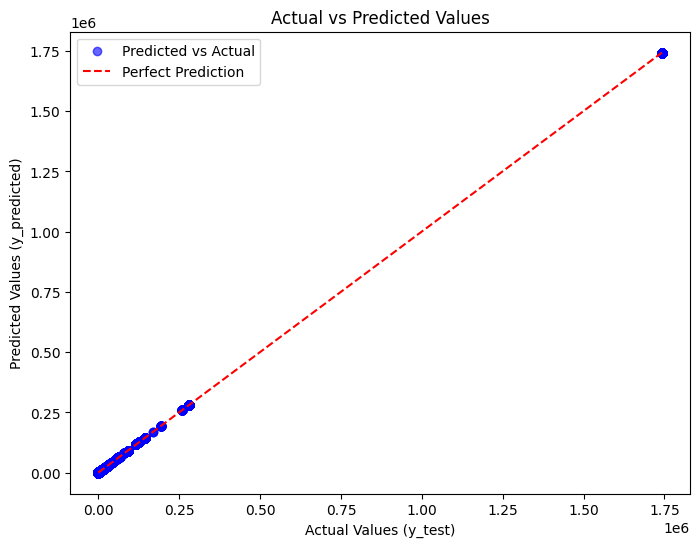

In [99]:
plt.figure(figsize=(8,6))

plt.scatter(y_test, y_predicted, alpha=0.6, color='b', label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--', label='Perfect Prediction')

plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_predicted)')
plt.title('Actual vs Predicted Values')

plt.legend()
plt.show()
